<a href="https://colab.research.google.com/github/jiku100/2020-2-machine-running-proejct/blob/master/assignment10/%EC%8B%A0%EC%84%9D%EA%B2%BD_assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification for Multiple Categories using Pytorch for best accuracy**



# 1. Import library
<hr>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


# 2. Preprocessing Data
<hr>

In [3]:
transform = transforms.Compose([
        transforms.ToTensor(),  
        transforms.Normalize((0.1307,),(0.3081,)),                      # 이미지를 텐서로 변형합니다.
])

In [4]:
data_path = './MNIST'

data_test   = datasets.MNIST(root = data_path, train= True, download=True, transform= transform)
data_train  = datasets.MNIST(root = data_path, train= False, download=True, transform= transform)

type of one image <class 'torch.Tensor'>
size of one image :  torch.Size([1, 28, 28])
type of label :  <class 'int'>
label :  7
255


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


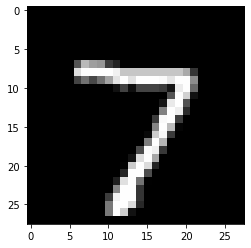

In [5]:
one_image, label = data_train[0]
print("type of one image", type(one_image))
print("size of one image : ", one_image.shape)
plt.imshow(one_image.squeeze().numpy(), cmap='gray')
print("type of label : ", type(label))
print("label : ", label)
print(np.max(data_train.train_data[0].view(-1).numpy()))

In [6]:
learning_rate = 0.001
training_epochs = 100
batch_size = 32
drop_prob = 0.4

In [7]:
train_loader = DataLoader(dataset = data_train, batch_size = batch_size, shuffle = True) ## batch size 32 짜리 train loader 생성
test_loader = DataLoader(dataset = data_test, batch_size = batch_size, shuffle = True) ## batch size 32 짜리 test loader 생성

# 3. Define Model
<hr>

In [34]:
class classification(nn.Module):
    def __init__(self):
        super(classification, self).__init__()
        
        # construct layers for a neural network
        self.classifier1 = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=20*20, bias = True),
            nn.BatchNorm1d(20*20),
            nn.ReLU(inplace=True),
            nn.Dropout(p=drop_prob)
        ) 
        self.classifier2 = nn.Sequential(
            nn.Linear(in_features=20*20, out_features=10*10, bias = True),
            nn.BatchNorm1d(10*10),
            nn.ReLU(inplace=True),
            nn.Dropout(p=drop_prob)
        ) 
        self.classifier3 = nn.Sequential(
            nn.Linear(in_features=100, out_features=10, bias = True),
            nn.LogSoftmax(dim=1),
        ) 

        for m in self.modules():
          if isinstance(m, nn.Linear):
            init.kaiming_normal_(m.weight.data) # Kaming He Initialization
            m.bias.data.fill_(0)                # 편차를 0으로 초기화 

    def forward(self, inputs):                 # [batchSize, 1, 28, 28]
        x = inputs.view(inputs.size(0), -1)    # [batchSize, 28*28]
        x = self.classifier1(x)                # [batchSize, 20*20]
        x = self.classifier2(x)                # [batchSize, 10*10]
        out = self.classifier3(x)              # [batchSize, 10]
        
        return out



In [35]:
model = classification().to(device)

In [44]:
criterion = nn.NLLLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.1, last_epoch=-1)

# 4. Training
<hr>

In [45]:
total_batch= len(train_loader)

In [46]:
print(total_batch)

313


In [47]:
def accuracy(log_pred, y_true):
    y_pred = torch.argmax(log_pred, dim=1)
    return (y_pred == y_true).to(torch.float).mean()

In [48]:
def training(model, loss, optim, training_epochs, train_loader, test_loader):
  L_iters_train = []
  accuracy_train = []
  L_iters_test = []
  accuracy_test = []
  for epoch in range(training_epochs):
    total_cost_train = 0
    total_cost_test = 0
    total_acc_train = 0
    total_acc_test = 0
    model.train()
    for X, Y in train_loader:
      X = X.to(device)
      Y = Y.to(device)

      optim.zero_grad()
      train_pred = model(X)
      cost = loss(train_pred, Y)
      cost.backward()
      optim.step()

      total_cost_train += cost
      total_acc_train += accuracy(train_pred, Y)
      
    avg_cost_train = total_cost_train / len(train_loader)
    avg_acc_train = total_acc_train / len(train_loader)

    L_iters_train.append(avg_cost_train)
    accuracy_train.append(avg_acc_train)
    model.eval()
    with torch.no_grad():
      for X_test, Y_test in test_loader:
        X_test = X_test.to(device)
        Y_test = Y_test.to(device)
        test_pred = model(X_test)
        cost_test = loss(test_pred, Y_test)
        total_cost_test += cost_test
        total_acc_test += accuracy(test_pred, Y_test)
      avg_cost_test = total_cost_test / len(test_loader)
      avg_acc_test = total_acc_test / len(test_loader)
    
      accuracy_test.append(avg_acc_test)
      L_iters_test.append(avg_cost_test)

    print("Epoch: %02d Training Loss: %.9f Testing Loss: %.9f  Training Acc: %.9f Testing Acc: %.9f" %((epoch + 1),avg_cost_train, avg_cost_test, avg_acc_train, avg_acc_test))
  return L_iters_train, accuracy_train, L_iters_test, accuracy_test

In [49]:
L_train, A_train, L_test, A_test = training(model, criterion, optimizer, training_epochs, train_loader, test_loader)

Epoch: 01 Training Loss: 0.701205671 Testing Loss: 0.289849430  Training Acc: 0.784045517 Testing Acc: 0.915333331
Epoch: 02 Training Loss: 0.349876583 Testing Loss: 0.231648475  Training Acc: 0.894568682 Testing Acc: 0.931066692
Epoch: 03 Training Loss: 0.290339500 Testing Loss: 0.199741811  Training Acc: 0.913438499 Testing Acc: 0.940016687
Epoch: 04 Training Loss: 0.235501438 Testing Loss: 0.184447274  Training Acc: 0.923722029 Testing Acc: 0.944500029
Epoch: 05 Training Loss: 0.205255821 Testing Loss: 0.176531255  Training Acc: 0.936002374 Testing Acc: 0.947750032
Epoch: 06 Training Loss: 0.177925065 Testing Loss: 0.165496632  Training Acc: 0.942292333 Testing Acc: 0.950266659
Epoch: 07 Training Loss: 0.161426783 Testing Loss: 0.160364836  Training Acc: 0.947284341 Testing Acc: 0.951533318
Epoch: 08 Training Loss: 0.145923585 Testing Loss: 0.150546134  Training Acc: 0.952775538 Testing Acc: 0.955616653
Epoch: 09 Training Loss: 0.143178344 Testing Loss: 0.144376308  Training Acc: 0.

KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize = (10,10))
plt.plot(L_train, linewidth = 2, c='b', label = "train")
plt.plot(L_test, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (10,10))
plt.plot(A_train, linewidth = 2, c='b', label = "train")
plt.plot(A_test, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

In [ ]:
print("training loss    %.2f" %(L_train))
print("testing loss     %.2f" %(L_test))
print("training acc    %.2f" %(A_train))
print("testing acc     %.2f" %(A_test))

# 5. Output
<hr>

## 1. Plot the training and testing losses with a batch size of 32

## 2. Plot the training and testing accuracies with a batch size of 32

## 3. Plot the training and testing losses with a batch size of 64

## 4. Plot the training and testing accuracies with a batch size of 64

## 5. Plot the training and testing losses with a batch size of 128

## 6. Plot the training and testing accuracies with a batch size of 128

## 7. Print the loss at convergence with different mini-batch sizes

## 8. Print the accuracy at convergence with different mini-batch sizes